# Hierarchical Star - Spectroscopic Observables

This notebook shows how you can use the `MultieStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [1]:
import json
import numpy as np
import pandas as pd
import numpyro, jax
import arviz as az
import matplotlib.pyplot as plt

from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value
from numpyro.infer.reparam import LocScaleReparam
from time import time

num_chains = 4
numpyro.enable_x64()
numpyro.set_host_device_count(num_chains)

In [2]:
try:
    gpu = jax.devices('gpu')[0]
except RuntimeError:
    gpu = None

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Then, import the `HierarchicalStarModel` from `celestify`.

In [3]:
from celestify.numpyro_models import HierarchicalStarModel

2024-02-15 17:11:43.051692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 17:11:43.051720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 17:11:43.052689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 17:11:43.616868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [4]:
rng = random.PRNGKey(0)  # create random key to use throughout notebook

In [5]:
# hyperparam_names = ["mu_Y", "mu_a", "sigma_Y", "sigma_a"]
# hyperparam_names = ["dY_dZ", "sigma_Y", "da_dM", "sigma_a"]
# hyperparam_names = ["dY_dZ", "sigma_Y", "mu_a", "sigma_a"]

In [6]:
# rng = random.PRNGKey(0)  # create random key to use throughout notebook
# num_stars = 100

# rng, key = random.split(rng)
# true_model = HierarchicalStarModel(num_stars)
# truths = {
#     # "mu_Y": 0.27,
#     "dY_dZ": 1.5,
#     "sigma_Y": 0.005,
#     # "mu_a": 2.0,
#     "da_dM": -0.3,
#     "sigma_a": 0.05,
# }
# # This samples from the true model given some random key
# true_trace = handlers.trace(
#     handlers.seed(handlers.substitute(true_model, truths), key)
# ).get_trace()
# truths.update({key: param["value"] for key, param in true_trace.items()})
# pprint(truths)

In [7]:
filename = "/mnt/data-storage/alexlyttle/scalable-stellar-inference/truths-nearest-neighbour.csv"
df = pd.read_csv(filename, index_col=0)
df

track  star  star_mass     Yinit     Zinit      amlt  fov_core  \
5135942   4716    64    1.21899  0.255556  0.004416  1.789752  0.000315   
1047516    572   114    1.18823  0.256612  0.003238  2.030292  0.000000   
2374686   2422   832    1.86401  0.255684  0.004760  2.040546  0.014332   
4145653   6183   102    0.94165  0.278359  0.022493  1.983209  0.000000   
3861544   1731   120    1.15933  0.285274  0.023931  1.880585  0.000000   
...        ...   ...        ...       ...       ...       ...       ...   
1854696   3799   380    1.00815  0.273238  0.009368  2.062762  0.000000   
1322310    988   363    1.10386  0.263838  0.005982  1.950995  0.000000   
5302278   4984   160    0.96587  0.255751  0.002633  2.033112  0.000000   
1322043    988    96    1.10386  0.263838  0.005982  1.950995  0.000000   
3226063   5735   149    0.92134  0.274941  0.019122  2.148639  0.000000   

         fov_shell      star_age    radius  ...     log_g     log_L   delta_X  \
5135942   0.006041  2.053233e+09  1.370623  ...  4.250232  0.661895  0.529330   
1047516   0.006041  2.775791e+09  1.465378  ...  4.181069  0.764061  0.739037   
2374686   0.006041  9.790699e+08  5.314918  ...  3.257523  1.560242  0.739556   
4145653   0.006041  9.238255e+09  0.968621  ...  4.439649 -0.120005  0.487927   
3861544   0.006041  5.699361e+09  1.477156  ...  4.163422  0.375042  0.690712   
...            ...           ...       ...  ...       ...       ...       ...   
1854696   0.006041  8.890225e+09  4.576233  ...  3.120576  1.045949  0.717394   
1322310   0.006041  5.476578e+09  3.620299  ...  3.363493  0.890947  0.730180   
5302278   0.006041  5.988625e+09  1.347535  ...  4.163906  0.476824  0.738460   
1322043   0.006041  3.676525e+09  1.416278  ...  4.178685  0.524092  0.713508   
3226063   0.006041  1.343972e+10  1.080664  ...  4.335107  0.019266  0.696026   

            f_nuc  phase       EEP   bol_mag     abs_G    abs_BP    abs_RP  
5135942  1.000192      0  0.097247  3.095263  3.064094  3.207612  2.798840  
1047516  1.000001      0  0.169591  2.839847  2.821199  2.948562  2.583362  
2374686  1.057949      0  0.368276  0.849395  0.779131  1.029182  0.371158  
4145653  0.999883      0  0.105998  5.050013  4.977653  5.352141  4.440660  
3861544  1.000128      0  0.142149  3.812396  3.704555  4.010748  3.236899  
...           ...    ...       ...       ...       ...       ...       ...  
1854696  0.996020      0  0.557015  2.135128  2.173508  2.641750  1.550712  
1322310  0.996985      0  0.411047  2.522632  2.538278  2.968419  1.946027  
5302278  0.999890      0  0.207278  3.557939  3.528134  3.732733  3.169455  
1322043  1.000010      0  0.135843  3.439769  3.378705  3.585201  3.021342  
3226063  0.999994      0  0.169971  4.701836  4.620347  4.967586  4.109136  

[100000 rows x 36 columns]

In [8]:
df["L"] = 10**df["log_L"]
df["log_age"] = df["log_star_age"] - 9
df["age"] = 10**df["log_age"]

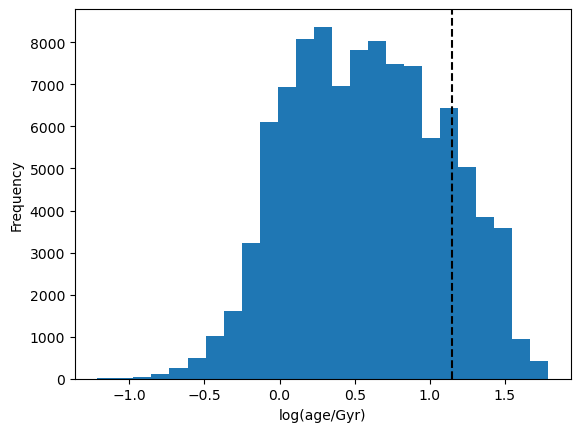

In [9]:
ax = df.log_age.plot(kind="hist", bins=25)
ax.axvline(np.log10(14), c="k", ls="--")
ax.set_xlabel("log(age/Gyr)");

In [10]:
truths_filepath = "/mnt/data-storage/alexlyttle/scalable-stellar-inference/truths.json"
# SAVE TRUTHS
with open(truths_filepath, "r") as file:
    s = file.read()
    truths = json.loads(s)


In [11]:
hyperparam_names = ["mu_a", "sigma_a", "Y_0", "dY_dZ", "sigma_Y"]
truths = {key: truths[key] for key in hyperparam_names}

In [12]:
num_stars = 20

rename_cols = {
    "EEP": "evol",
    "star_mass": "mass",
    "log_star_mass": "log_mass",
    "Yinit": "Y",
    "amlt": "a_MLT",
    "radius": "R",
    "log_radius": "log_R",
    "Dnu_freq_o": "Dnu",
    "log_Dnu_freq_o": "log_Dnu",
}

truths_ = df.iloc[:num_stars].rename(rename_cols, axis=1).to_dict(orient="list")
truths.update({key: np.array(value) for key, value in truths_.items()})

## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [13]:
rng, key = random.split(rng)

sigma_mh = 0.1
mu_mh = truths["M_H"] + sigma_mh * random.normal(key, shape=truths["M_H"].shape)  # add noise to metallicity prior

# Create dictionary of model constants
const = {
    "M_H": dict(loc=mu_mh, scale=sigma_mh),
    "Teff": dict(scale=75.),
    # "log_g": dict(scale=0.1),
    "L": dict(scale=0.01*truths["L"])
}

# Create model
model = HierarchicalStarModel(num_stars, const=const)

pprint(model.const)  # check all constants

2024-02-15 17:11:49.209018: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


{'L': {'scale': array([0.04590869, 0.05808464, 0.36328047, 0.00758569, 0.02371601,
       0.00659388, 0.10671636, 0.04157221, 0.01173688, 0.19100435,
       0.38225039, 0.0403796 , 0.15231861, 0.07126511, 0.03321361,
       0.00315089, 0.25380245, 0.0426172 , 0.03976888, 0.01586857])},
 'M_H': {'loc': Array([-0.54844724, -0.69728853, -0.72377954,  0.20217919,  0.34547544,
        0.25002652, -0.73614242, -0.05610763, -0.84882507, -0.5052747 ,
       -0.3041417 ,  0.25058277, -0.59418784,  0.09110183, -0.23329177,
       -0.34421618, -0.07594939, -0.1585463 ,  0.37194951,  0.03768626],      dtype=float64),
         'scale': 0.1},
 'Teff': {'scale': 75.0},
 'Y_0': {'loc': 0.247, 'scale': 0.001},
 'dY_dZ': {'high': 3.0, 'low': 0.0},
 'log_evol': {'loc': -0.7, 'scale': 0.4},
 'log_mass': {'loc': 0.0, 'scale': 0.3},
 'mu_a': {'high': 2.5, 'low': 1.5},
 'precision': {'df': Array(4.18473434, dtype=float64, weak_type=True),
               'loc': Array([ 5.58302971e-04,  1.05638668e-04, -5.0787

## Prior Predictive

Sample from the model prior.

In [14]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=1000)
with jax.default_device(gpu):
    prior_samples = prior_predictive(key)

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [15]:
outputs = ["log_age", "log_Teff", "log_R", "log_Dnu"]
coords = {"star": np.arange(num_stars), "outputs": outputs}
dims = {}
for key, value in prior_samples.items():
    dims[key] = dim = []
    if value.ndim == 1:
        continue
    if value.shape[1] == len(outputs):
        dim.append("outputs")
    if value.shape[-1] == num_stars:
        dim.append("star")

data = az.from_numpyro(prior=prior_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

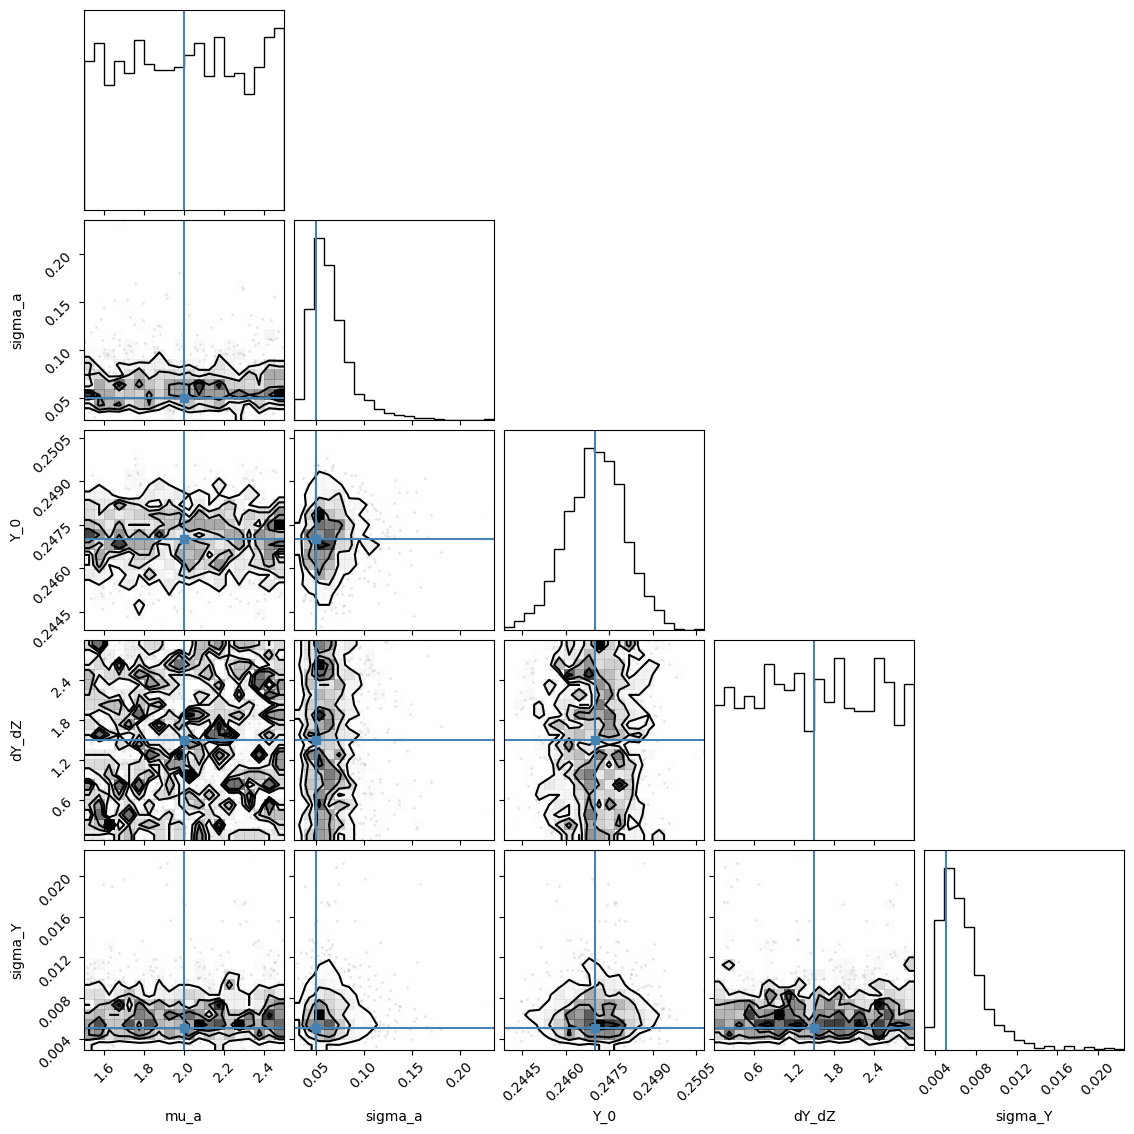

In [16]:
fig = corner(data, group="prior", var_names=hyperparam_names, truths=truths)

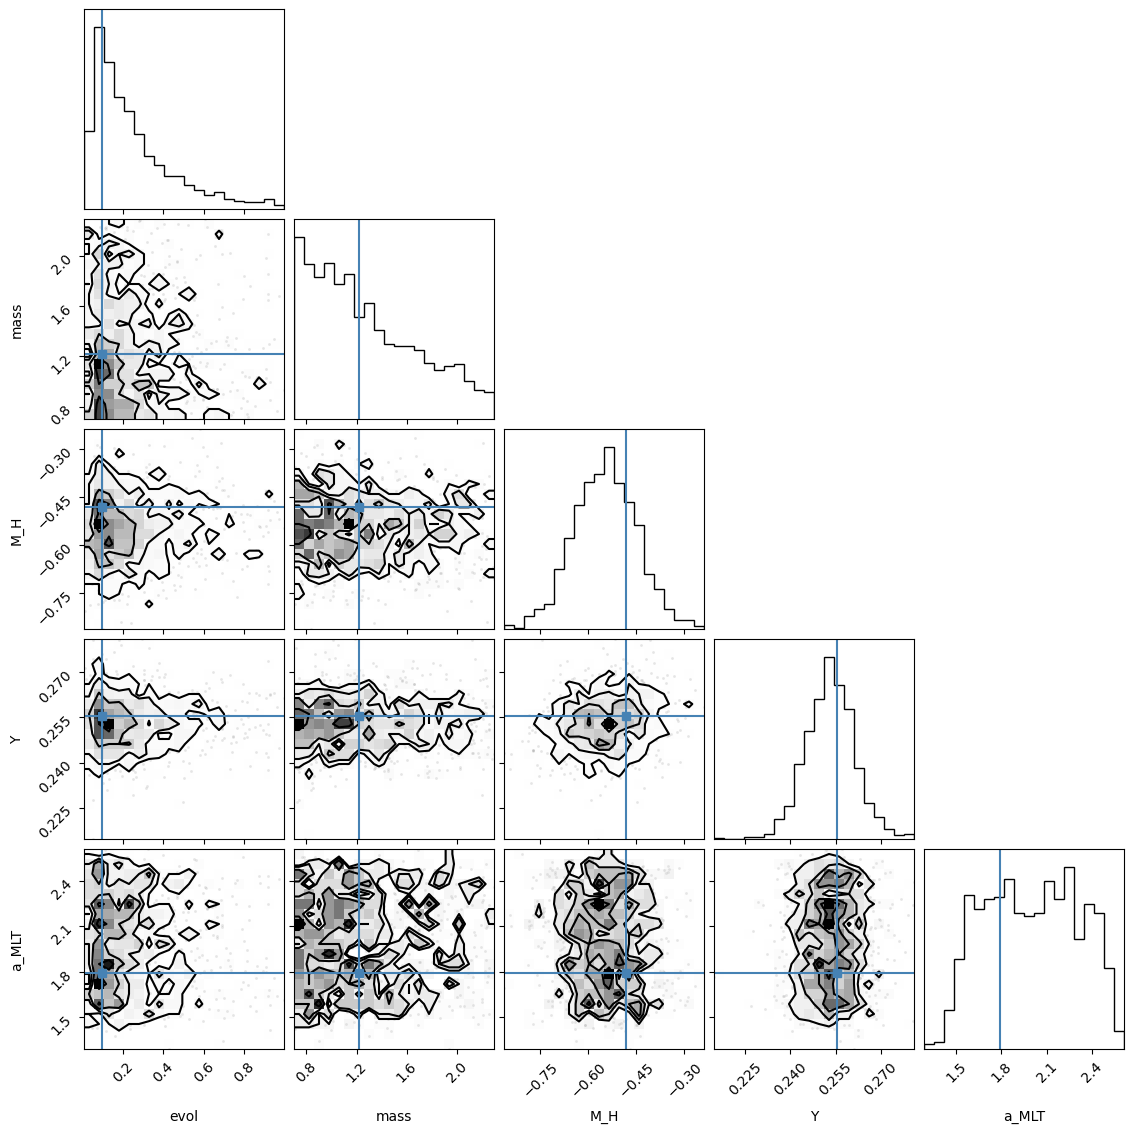

In [17]:
star = 0
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

Let's also look at some determinisitc parameters in the model.

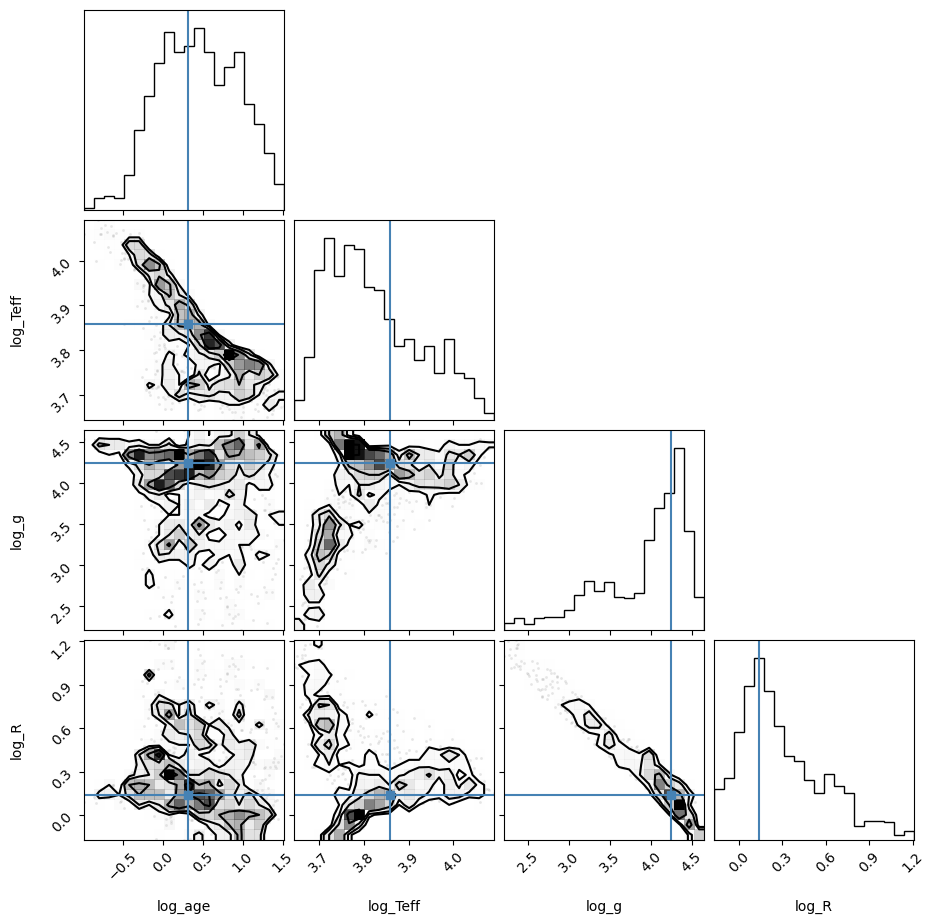

In [18]:
star = 0
var_names = ["log_age", "log_Teff", "log_g", "log_R"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

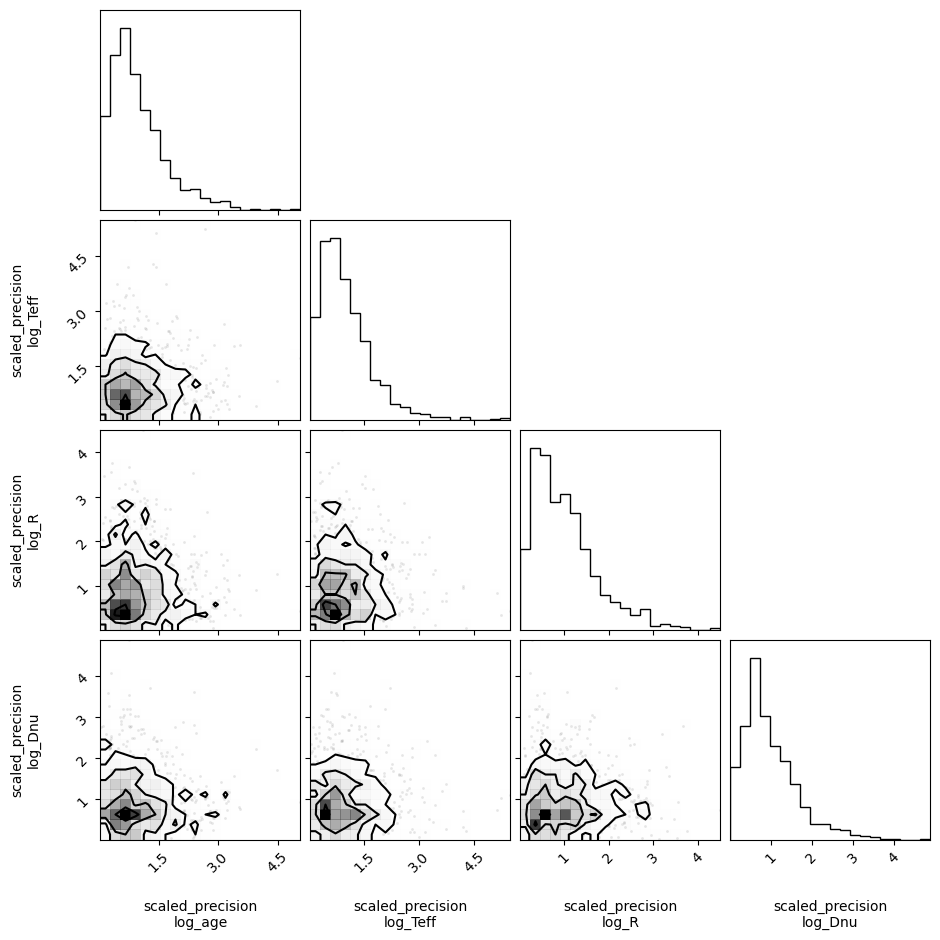

In [19]:
var_names = "scaled_precision"
fig = corner(data, group="prior", var_names=var_names, coords=coords_)

## Observation

Now we synthesize observable parameters for the model.

In [20]:
rng, *keys = random.split(rng, 3)
obs = {
    "Teff": truths["Teff"] + const["Teff"]["scale"] * random.normal(keys[0], shape=truths["Teff"].shape),
    # "log_g": truths["log_g"] + const["log_g"]["scale"] * random.normal(keys[1], shape=truths["log_g"].shape),
    "L": truths["L"] + const["L"]["scale"] * random.normal(keys[1], shape=truths["log_L"].shape),
}
pprint(obs)

{'L': Array([ 4.68597867,  5.87767294, 35.38892526,  0.75647735,  2.32310167,
        0.65738426, 10.66933762,  4.11169861,  1.18321521, 18.92908467,
       38.23961882,  4.0298451 , 15.27781122,  7.0538149 ,  3.32351311,
        0.31940243, 25.63845666,  4.21421906,  3.98251436,  1.60292546],      dtype=float64),
 'Teff': Array([7390.36438956, 7429.68517737, 5985.30973427, 5326.76223845,
       5923.38822199, 5277.78344777, 5116.62549709, 5347.33080603,
       6065.03471908, 8739.08833785, 4564.67838241, 4604.82015854,
       9953.13354167, 4698.80025339, 6360.721547  , 5177.28668966,
       9693.17834958, 6666.67110388, 6219.17036041, 4979.03684334],      dtype=float64)}


## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [21]:
# good_stars = np.array([i for i in range(num_stars) if i not in bad_stars], dtype=int)


In [22]:
# model.num_stars = len(good_stars)
# model.const["M_H"]["loc"] = const["M_H"]["loc"][good_stars]

In [23]:
# good_obs = {k: v[good_stars] for k, v in obs.items()}

In [24]:
# sampler = NUTS(model, target_accept_prob=0.8, dense_mass=[("dY_dZ", "da_dM", "sigma_Y", "sigma_a")], init_strategy=init_to_median)
sampler = NUTS(model, target_accept_prob=0.8, init_strategy=init_to_median)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=num_chains)

Let's run the MCMC and print a summary of results.

In [25]:
rng, key = random.split(rng)
start = time()
# with jax.default_device(gpu):
    # mcmc.run(key, obs=obs)
mcmc.run(key, obs=obs)
elapsed_time = time() - start
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             M_H[0]     -0.55      0.10     -0.55     -0.72     -0.40   1549.93      1.00
             M_H[1]     -0.68      0.10     -0.68     -0.84     -0.52   1138.17      1.00
             M_H[2]     -0.71      0.09     -0.72     -0.87     -0.56   1798.60      1.00
             M_H[3]      0.21      0.09      0.21      0.06      0.36   2421.36      1.00
             M_H[4]      0.30      0.07      0.31      0.21      0.40   2688.36      1.00
             M_H[5]      0.24      0.09      0.25      0.12      0.39   2402.15      1.00
             M_H[6]     -0.73      0.09     -0.73     -0.88     -0.59   2347.80      1.00
             M_H[7]     -0.05      0.10     -0.05     -0.21      0.12   1750.02      1.00
             M_H[8]     -0.79      0.07     -0.80     -0.90     -0.69   2789.72      1.00
             M_H[9]     -0.53      0.09     -0.53     -0.68     -0.39    729.86      1.01
         

Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

**Note:** The `MultiStarModel` takes longer than running `SingleStarModel` sequentially, but includes population-level priors. It's worth looking at other ways to do this faster.

Let's update our `InferenceData`.

In [26]:
with jax.default_device(gpu):
    data += az.from_numpyro(mcmc, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

With `arviz`, we can create a summary of the data.

In [28]:
summary = az.summary(data, fmt="xarray")
summary

<xarray.Dataset>
Dimensions:           (star: 20, metric: 9, outputs: 4)
Coordinates:
  * star              (star) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
  * outputs           (outputs) <U8 'log_age' 'log_Teff' 'log_R' 'log_Dnu'
  * metric            (metric) <U9 'mean' 'sd' 'hdi_3%' ... 'ess_tail' 'r_hat'
Data variables: (12/30)
    Dnu               (metric, star) float64 88.77 77.45 13.46 ... 1.1 1.117
    L                 (metric, star) float64 4.683 5.875 35.39 ... 1.001 1.0 1.0
    M_H               (metric, star) float64 -0.5533 -0.6782 ... 1.023 1.005
    R                 (metric, star) float64 1.32 1.462 5.552 ... 1.022 1.017
    Teff              (metric, star) float64 7.393e+03 7.434e+03 ... 1.026 1.018
    Y                 (metric, star) float64 0.2825 0.2484 0.2661 ... 1.33 1.372
    ...                ...
    numax             (metric, star) float64 1.864e+03 1.55e+03 ... 1.107 1.2
    precision_Y       (metric) float64 2.28e+04 1.986e+04 8.811 ... 34.61 1.527
    precision_a       (metric) float64 230.4 196.6 0.06522 ... 7.167 28.75 1.528
    scaled_precision  (metric, outputs, star) float64 0.9675 0.9911 ... 1.001
    sigma_Y           (metric) float64 0.05453 0.08489 0.003017 ... 34.61 1.527
    sigma_a           (metric) float64 0.5871 0.9385 0.03127 ... 28.75 1.53

In [ ]:
efficiency = summary.sel(metric="ess_bulk") / elapsed_time

In [ ]:
efficiency

<xarray.Dataset>
Dimensions:           (star: 100, outputs: 4)
Coordinates:
  * star              (star) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * outputs           (outputs) <U8 'log_age' 'log_Teff' 'log_R' 'log_Dnu'
    metric            <U9 'ess_bulk'
Data variables: (12/30)
    Dnu               (star) float64 0.09289 0.1218 0.09021 ... 0.002204 0.04574
    L                 (star) float64 1.201 1.182 1.013 ... 1.269 0.8345 1.176
    M_H               (star) float64 0.08974 0.04978 0.1302 ... 0.002195 0.1905
    R                 (star) float64 0.8615 1.306 0.3607 ... 0.008399 0.1207
    Teff              (star) float64 0.9317 1.266 0.3935 ... 0.009026 0.1255
    Y                 (star) float64 0.05802 0.1132 0.06784 ... 0.002243 0.07367
    ...                ...
    numax             (star) float64 0.07722 0.09358 0.09218 ... 0.002208 0.0435
    precision_Y       float64 0.001802
    precision_a       float64 0.02964
    scaled_precision  (outputs) float64 0.1994 0.1056 0.09238 0.1762
    sigma_Y           float64 0.001802
    sigma_a           float64 0.02964

In [ ]:
values = []
for value in efficiency.values():
    values.append(np.atleast_1d(value))

eff = np.concatenate(values)

Text(0, 0.5, 'Count')

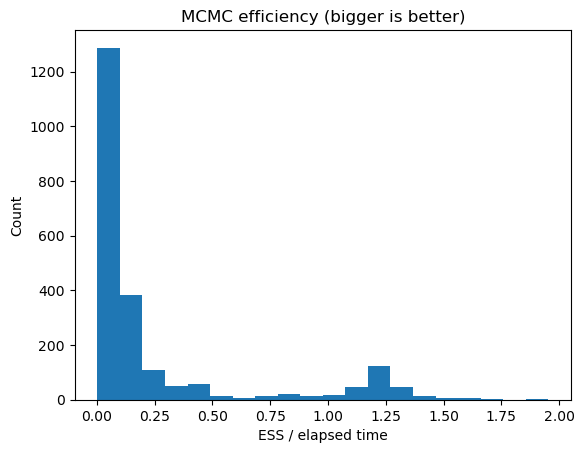

In [ ]:
fig, ax = plt.subplots()

ax.hist(eff, bins=20)
ax.set_title("MCMC efficiency (bigger is better)")
ax.set_xlabel("ESS / elapsed time")
ax.set_ylabel("Count")

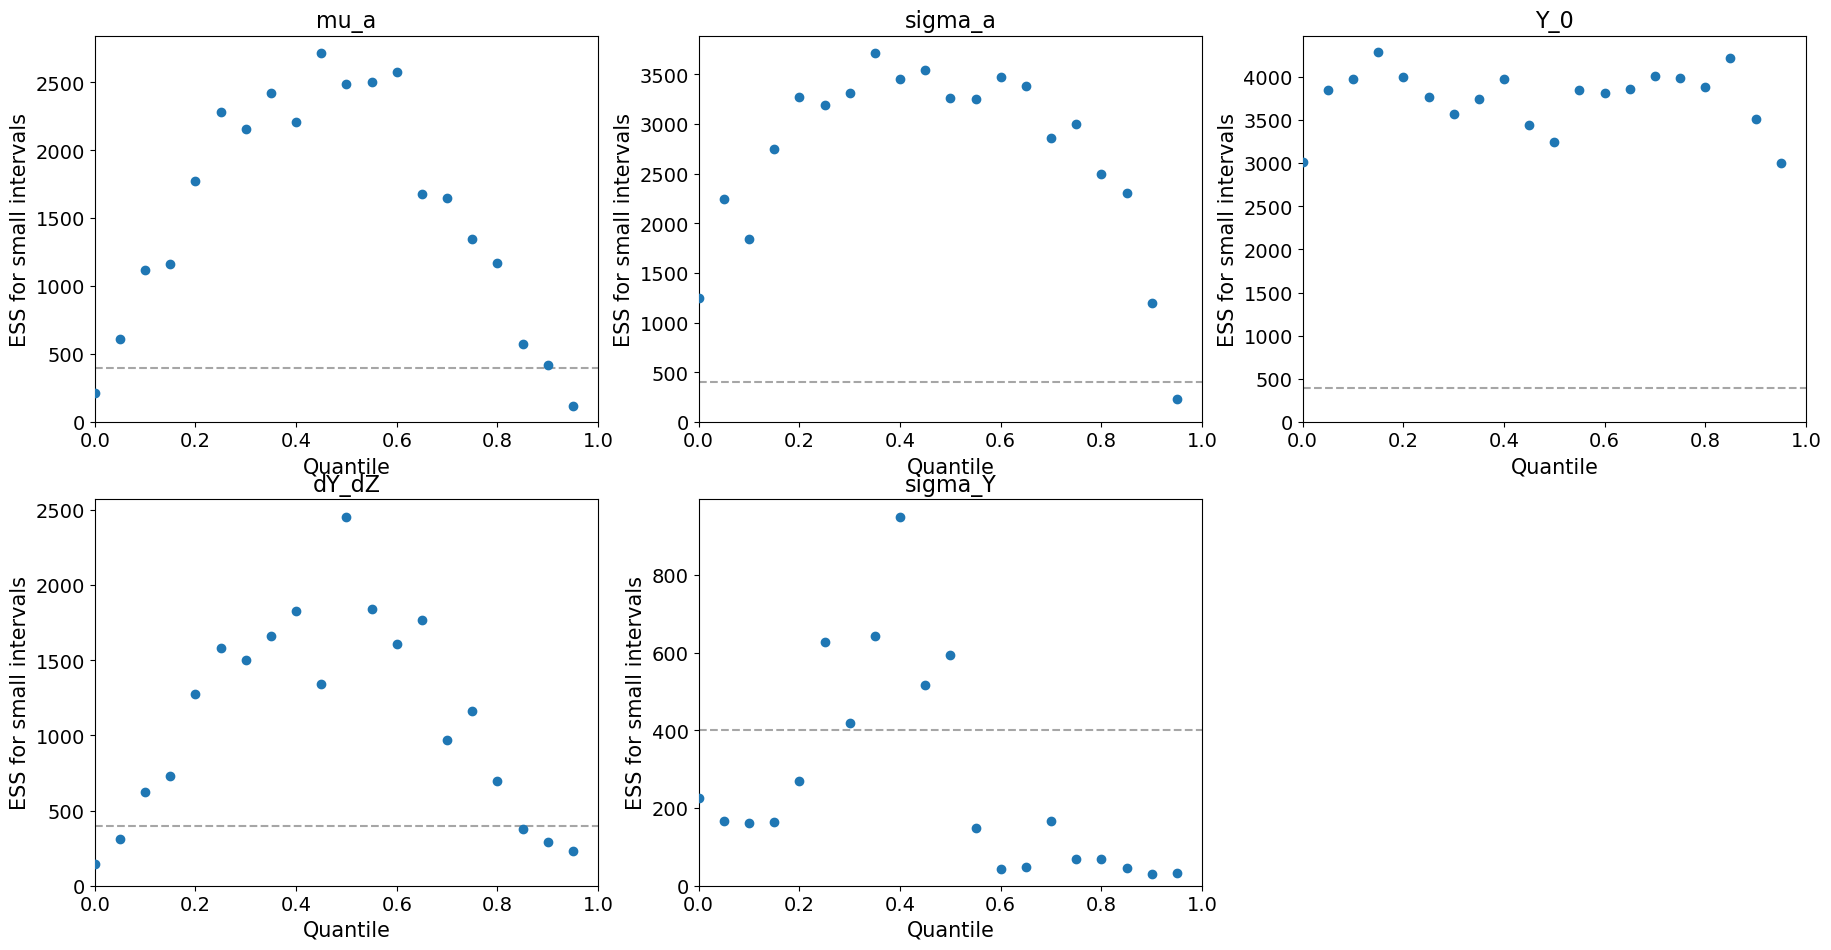

In [ ]:
az.plot_ess(data, var_names=hyperparam_names);

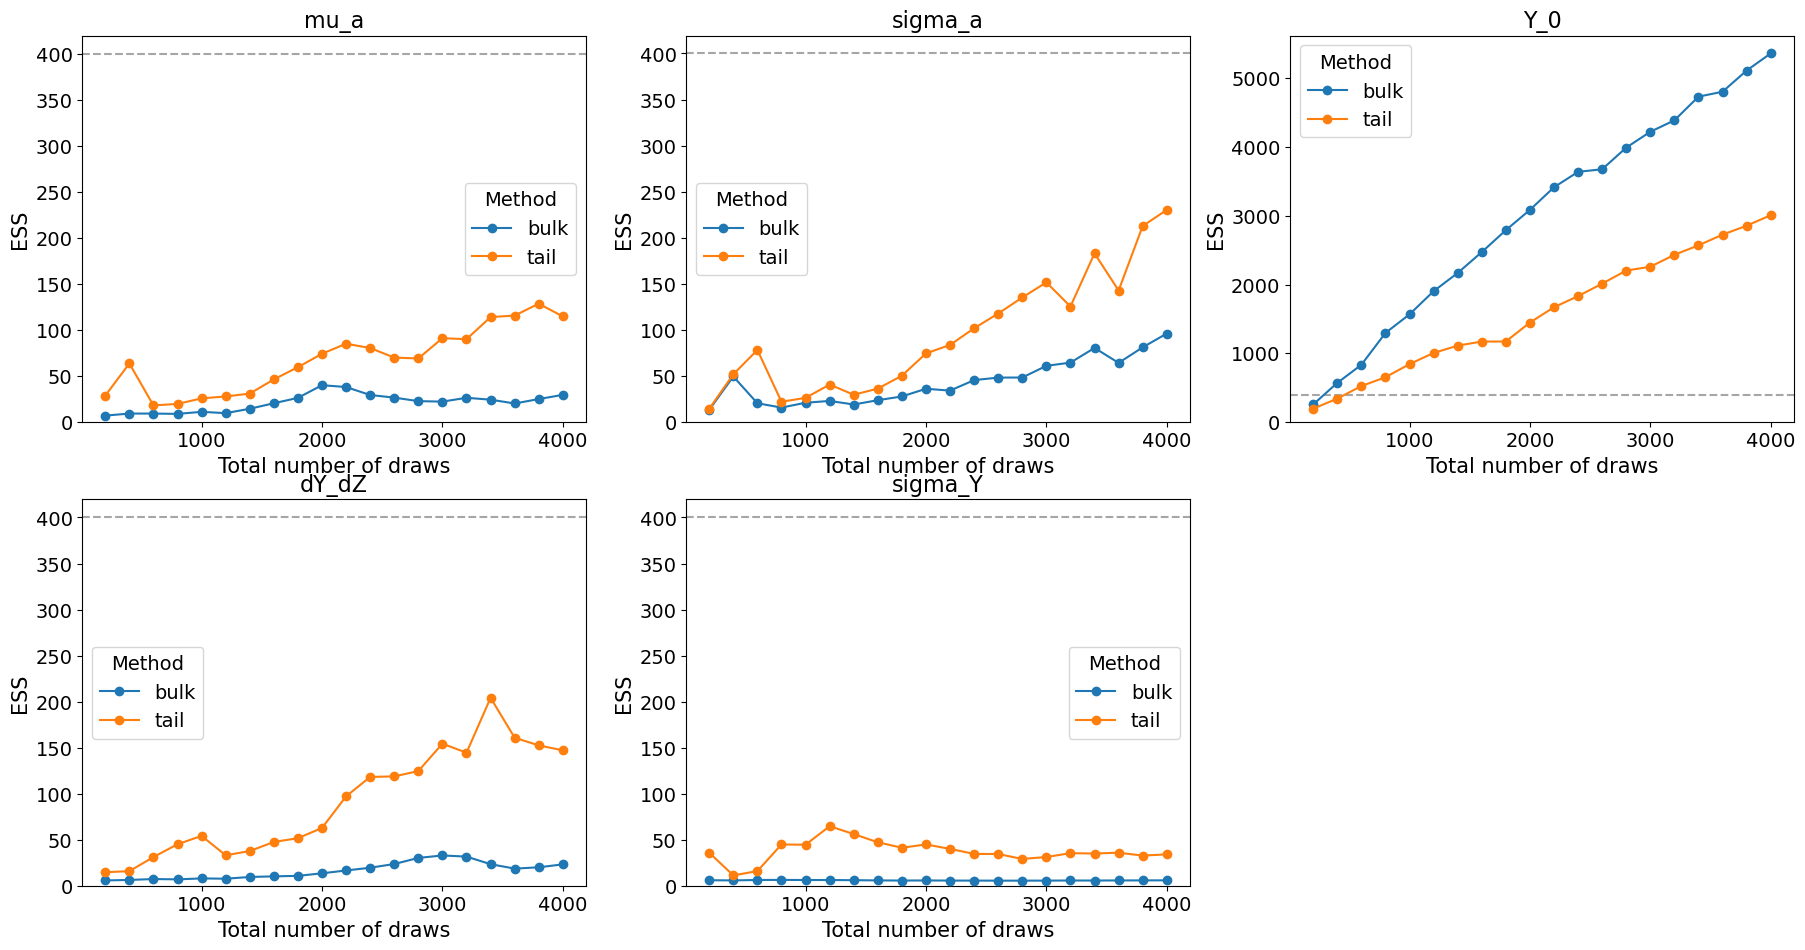

In [ ]:
az.plot_ess(data, kind="evolution", var_names=hyperparam_names);

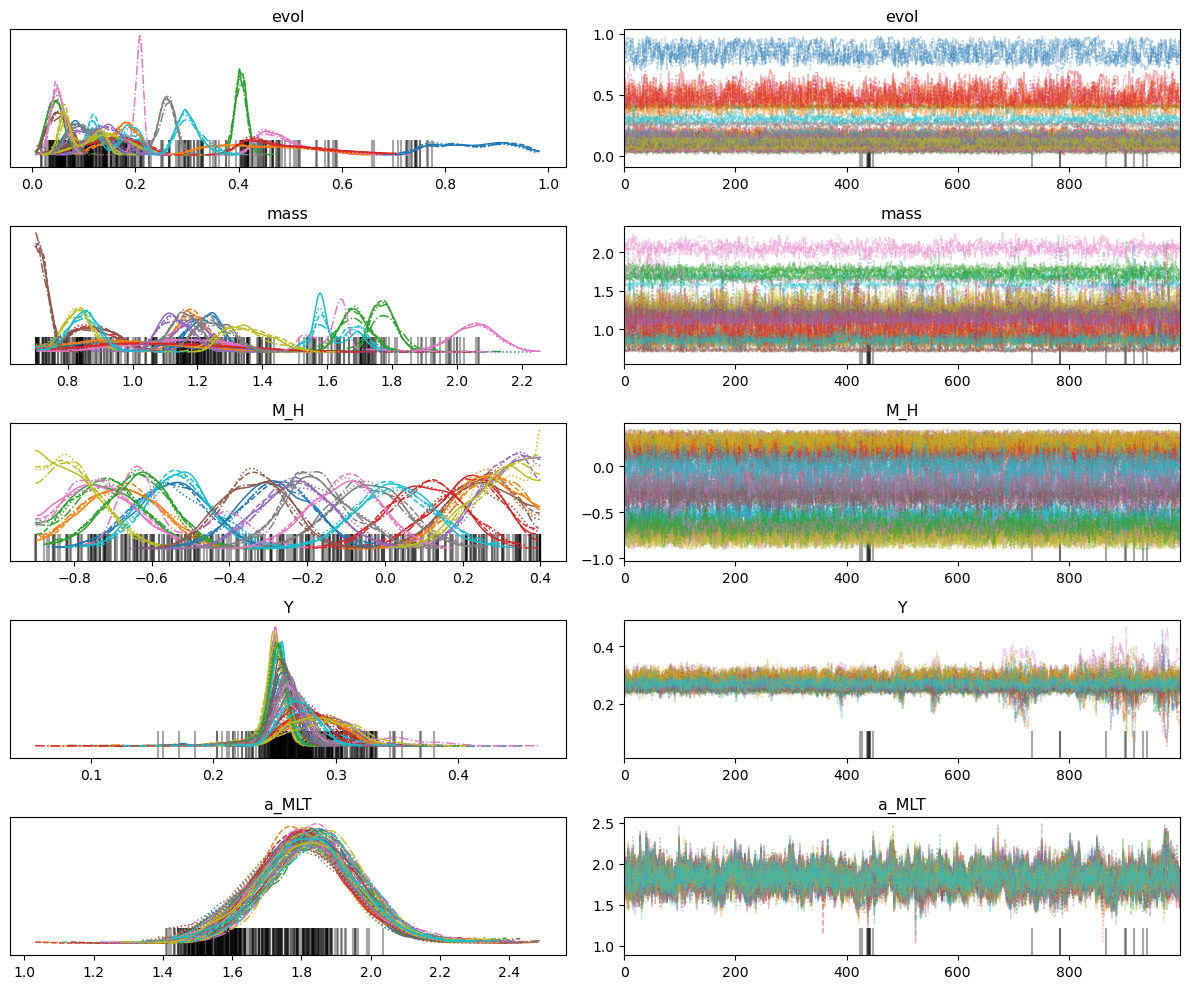

In [27]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
az.plot_trace(data, var_names=var_names, coords=dict(star=range(num_stars)))
# az.plot_trace(data, var_names=var_names, coords=dict(star=good_stars[:10]))
plt.tight_layout()

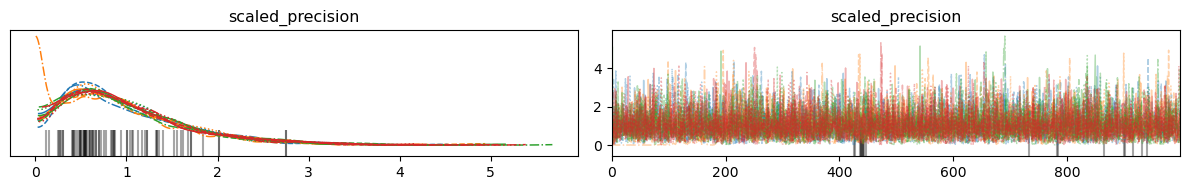

In [28]:
az.plot_trace(data, var_names="scaled_precision")
plt.tight_layout()

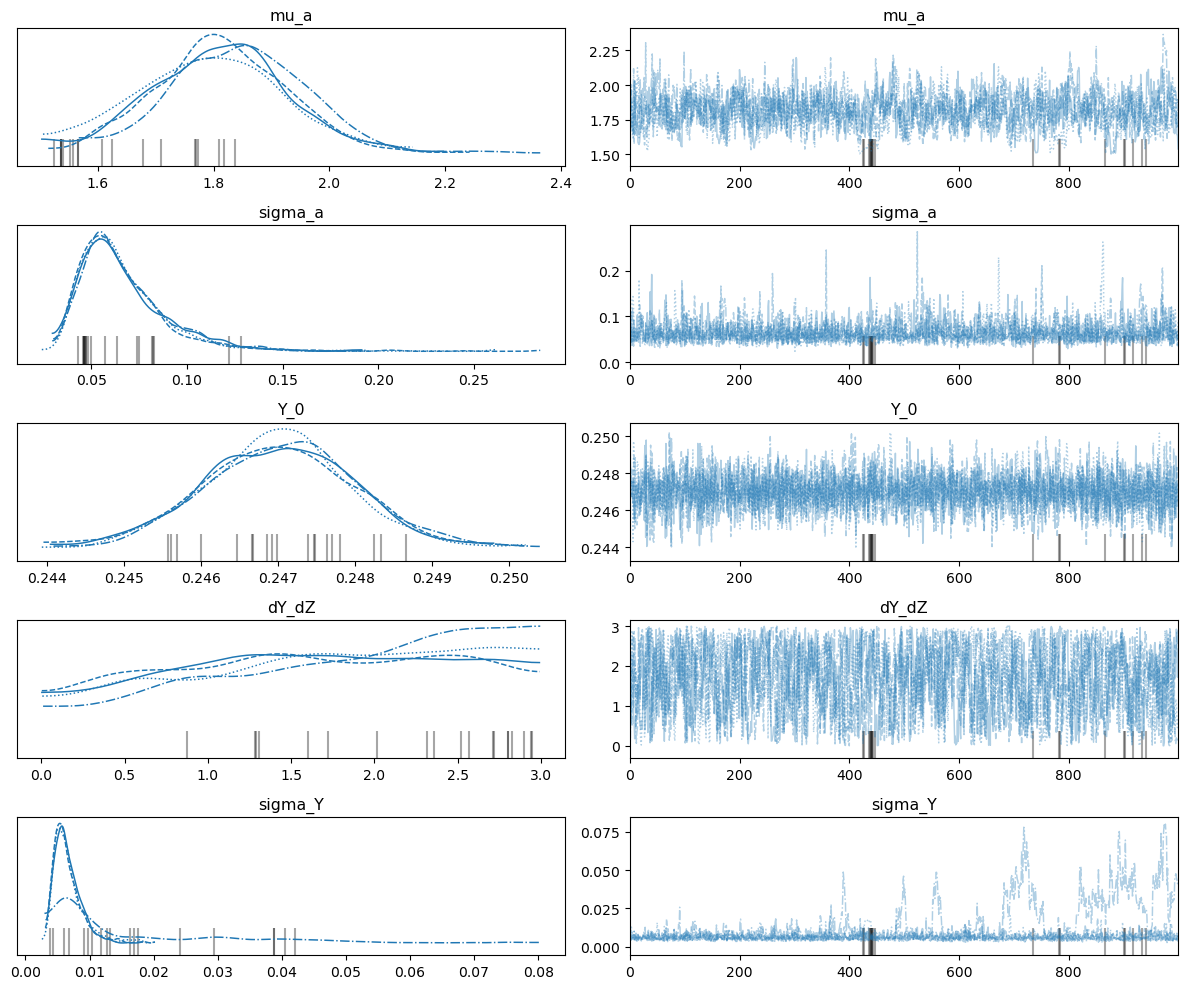

In [29]:
az.plot_trace(data, var_names=hyperparam_names)
plt.tight_layout()

In [63]:
from matplotlib import colormaps

In [73]:
colormaps["viridis"](0.5)

(0.127568, 0.566949, 0.550556, 1.0)

Text(0.5, 1.0, 'Covariance matrix')

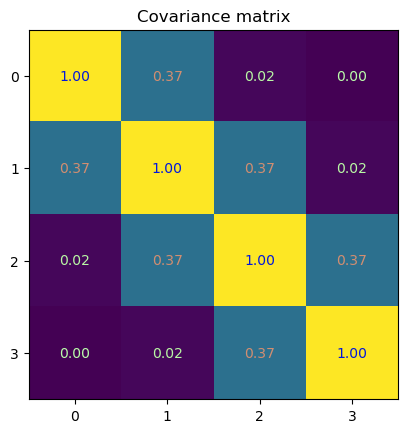

In [75]:
indices = np.arange(4)
cov = np.exp(- (indices - indices[:, None])**2)

cmap = colormaps["viridis"]

fig, ax = plt.subplots()
im = ax.imshow(cov, cmap=cmap)
for i in indices:
    for j in indices:
        z = cov[i, j]
        c = [1 - x for x in cmap(z)[:-1]]  # invert color
        ax.text(i, j, f"{z:.2f}", c=c, horizontalalignment="center", verticalalignment="center")

ax.xaxis.get_major_locator().set_params(integer=True)
ax.yaxis.get_major_locator().set_params(integer=True)
ax.set_title("Covariance matrix")

In [49]:
tril = np.linalg.cholesky(cov)
assert np.isclose(cov, tril @ tril.T).all()

In [51]:
u = 10.0
scale_tril = tril * u**-0.5
assert np.isclose(cov/u, scale_tril @ scale_tril.T).all()

In [85]:
from celestify import PACKAGEDIR
import json, os
import jax.numpy as jnp

In [78]:
with open(os.path.join(PACKAGEDIR, "data/emulator_error.json"), "r") as file:
    params = json.loads(file.read())

In [453]:
df = jnp.array(params["df"])
loc = jnp.array(params["mu"])
scale =  jnp.array(np.sqrt(params["theta"]))
L_omega = jnp.array(params["L_omega"])

In [454]:
scale_tril = scale[:, None] * L_omega

In [455]:
a = np.stack([[0.0, 1.0, 0.0, 0.0], 
              [0.0, 4.0, 2.0, 0.0]]) * np.log(10.0)
a

array([[0.        , 2.30258509, 0.        , 0.        ],
       [0.        , 9.21034037, 4.60517019, 0.        ]])

In [456]:
transformed_scale_tril = (a @ scale_tril)
cov = (transformed_scale_tril @ transformed_scale_tril.T)
cov

Array([[4.57671024e-06, 1.20219811e-05],
       [1.20219811e-05, 7.06755314e-05]], dtype=float64)

In [477]:
mu = np.log([5777., 1.0]) * np.ones((10, 2))

In [478]:
def unlog_cov(i, j):
    return np.exp(mu[..., i] + mu[..., j] + 0.5 * (cov[i, i] + cov[j, j])) * (np.exp(cov[i, j]) - 1)

# def unlog_cov(i, j):
#     return 10**(mu[i] + mu[j] + 0.5 * (cov[i, i] + cov[j, j])) * (10**(cov[i, j]) - 1)

In [479]:
indices = np.arange(2)
new_cov = unlog_cov(indices, indices[:, None])

In [480]:
new_cov.shape

(10, 2, 2)

In [446]:
# new_cov = np.full_like(transformed_cov, np.nan)
# new_cov[0, 0] = np.exp(transformed_cov[0, 0]) * (np.exp(transformed_cov[0, 0]) - 1)
# new_cov[1, 1] = np.exp(transformed_cov[1, 1]) * (np.exp(transformed_cov[1, 1]) - 1)
# new_cov[0, 1] = np.exp(0.5 * (transformed_cov[0, 0] + transformed_cov[1, 1]))  * (np.exp(transformed_cov[0, 1]) - 1)
# new_cov[1, 0] = np.exp(0.5 * (transformed_cov[0, 0] + transformed_cov[1, 1]))  * (np.exp(transformed_cov[1, 0]) - 1)
# new_cov

In [447]:
def unlog_mu(i):
    return np.exp(mu[i] + 0.5 * cov[i, i])

# def unlog_mu(i):
    # return 10**(mu[i] + 0.5 * cov[i, i])

In [464]:
a.shape

(2, 4)

In [463]:
jnp.matmul(a, outputs[..., None]).shape

(10, 2, 1)

In [448]:
new_mu = unlog_mu(indices)
new_mu

array([46.76328898,  2.71829995])

In [449]:
import numpyro.distributions as dist

In [450]:
# shape = (5000,)
# y = dist.MultivariateNormal(new_mu, covariance_matrix=new_cov).sample(rng, sample_shape=shape)
# log_y = dist.MultivariateNormal(0.0, covariance_matrix=transformed_cov).sample(rng, sample_shape=shape)

shape = (10000,)
keys = random.split(rng, 4)
scaled_precision = dist.Gamma(df/2, df/2).sample(keys[0], shape)

obs_scale = jnp.array([25.0, 0.01])

y = dist.MultivariateNormal(new_mu, covariance_matrix=new_cov/scaled_precision[:, None, None] + jnp.diag(obs_scale)**2).sample(keys[1])
# yp = dist.MultivariateNormal(new_mu+mu, scale_tril=new_scale_tril/scaled_precision[:, None, None]**0.5).sample(keys[2])
log_y = dist.MultivariateNormal(0.0, covariance_matrix=cov/scaled_precision[:, None, None] + (jnp.diag(obs_scale)/10**(mu))**2).sample(keys[3])

/home/alex/miniconda3/envs/celestify/lib/python3.10/site-packages/corner/core.py:922: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  return ax.set_ylim(new_ylim)
/home/alex/miniconda3/envs/celestify/lib/python3.10/site-packages/corner/core.py:922: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  return ax.set_ylim(new_ylim)


ValueError: It looks like the provided 'range' is not valid or the sample is empty.

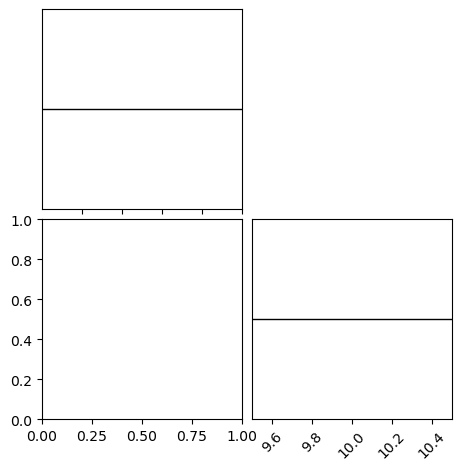

In [451]:
fig = None
limits = None
limits = [(6700., 7200.), (9.5, 10.5)]
fig = corner(np.array(y), bins=50, density=True, range=limits)
# fig = corner(np.array(yp), fig=fig, color="b", bins=50, density=True, range=limits)
fig = corner(np.power(10, log_y + mu), fig=fig, color="r", bins=50, density=True, range=limits)
# fig = corner(np.power(10, log_y), fig=fig, color="r")

In [387]:
np.std(y, axis=0)

Array([7.77930460e+01, 1.51442386e-02], dtype=float64)

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

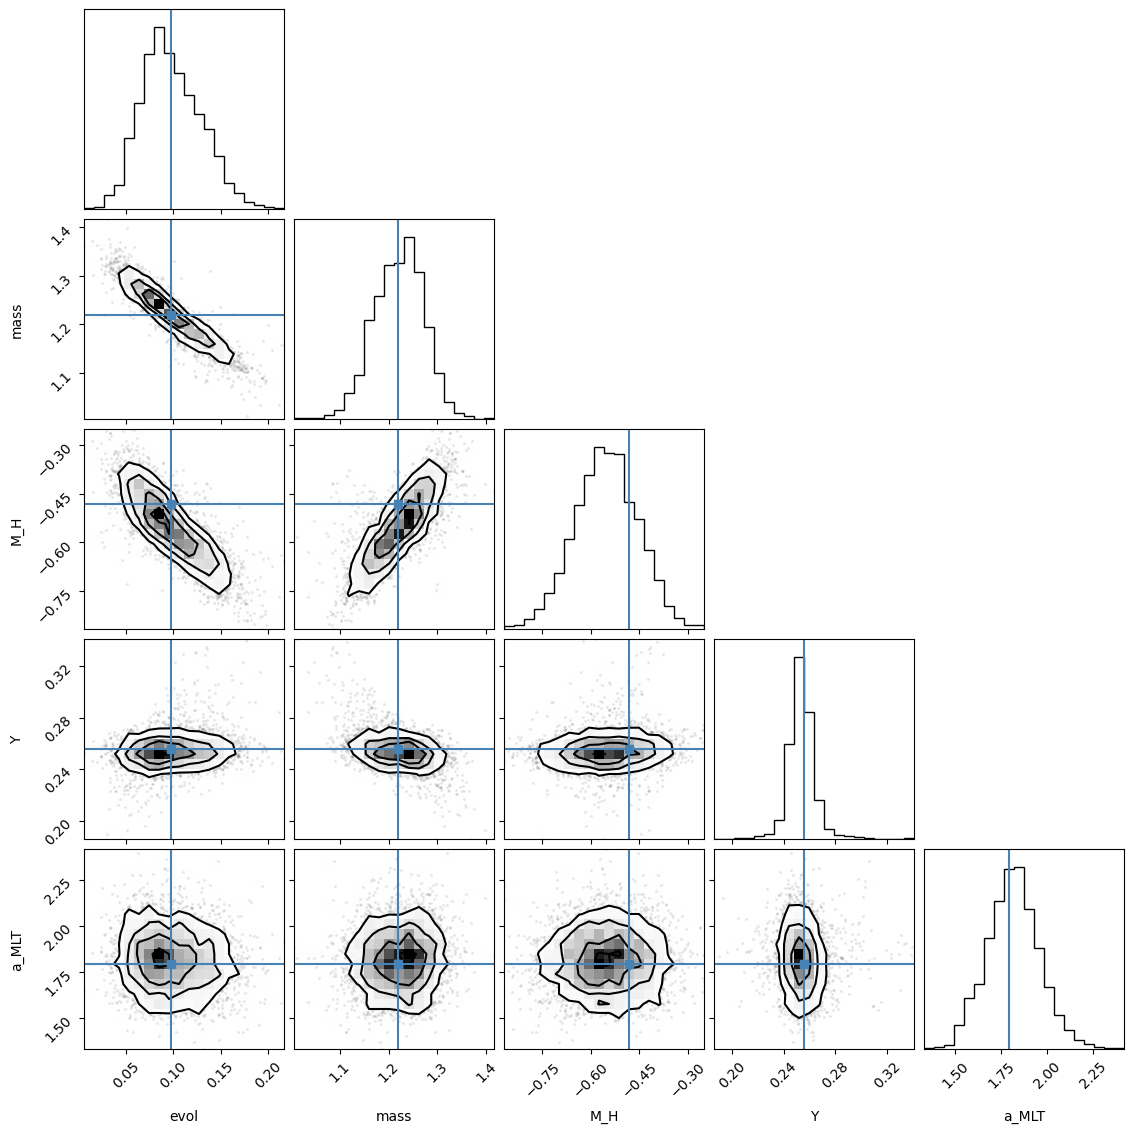

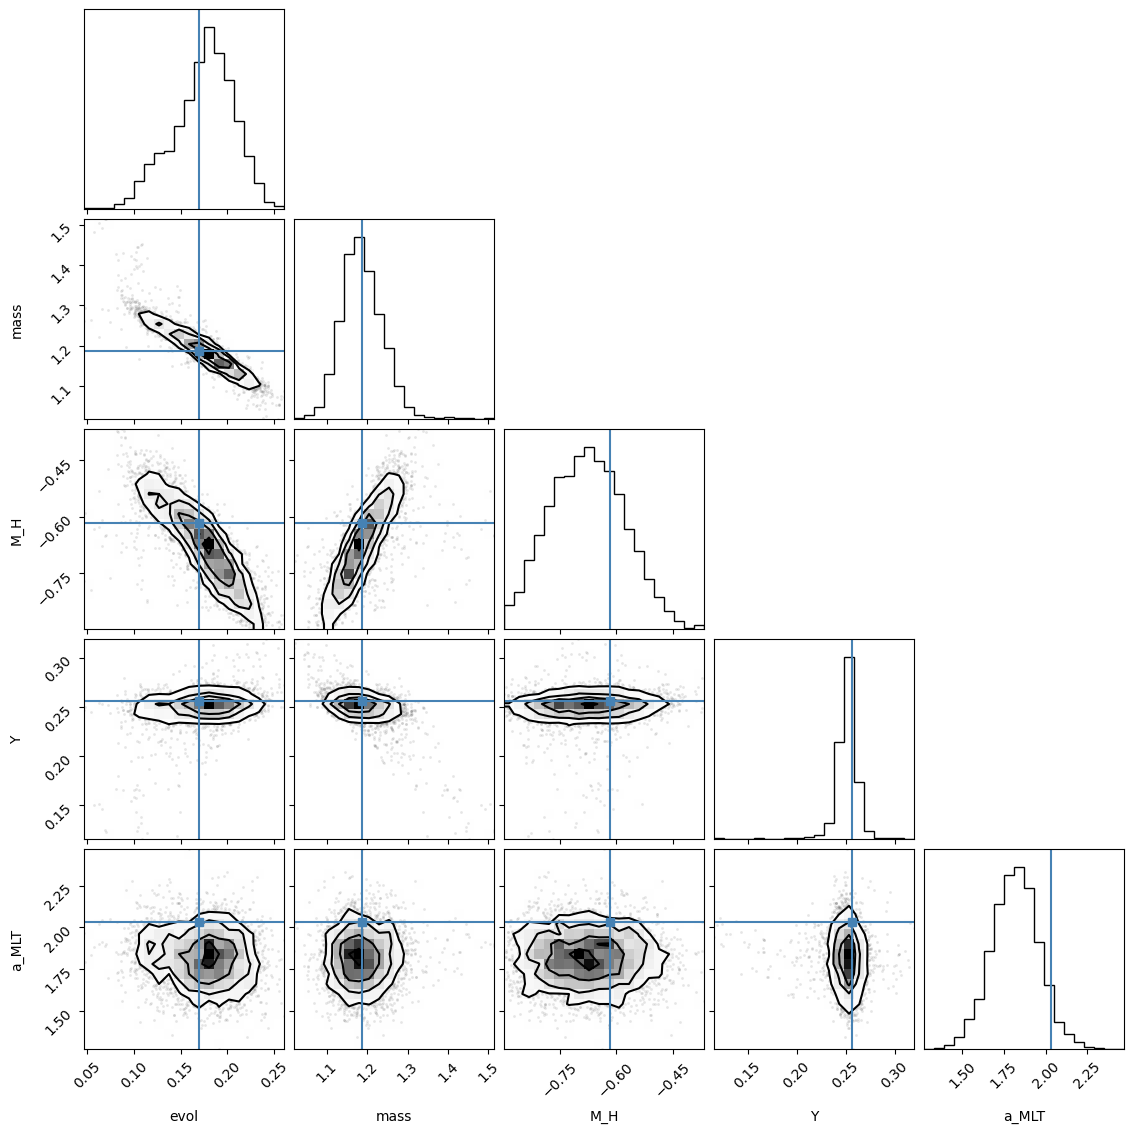

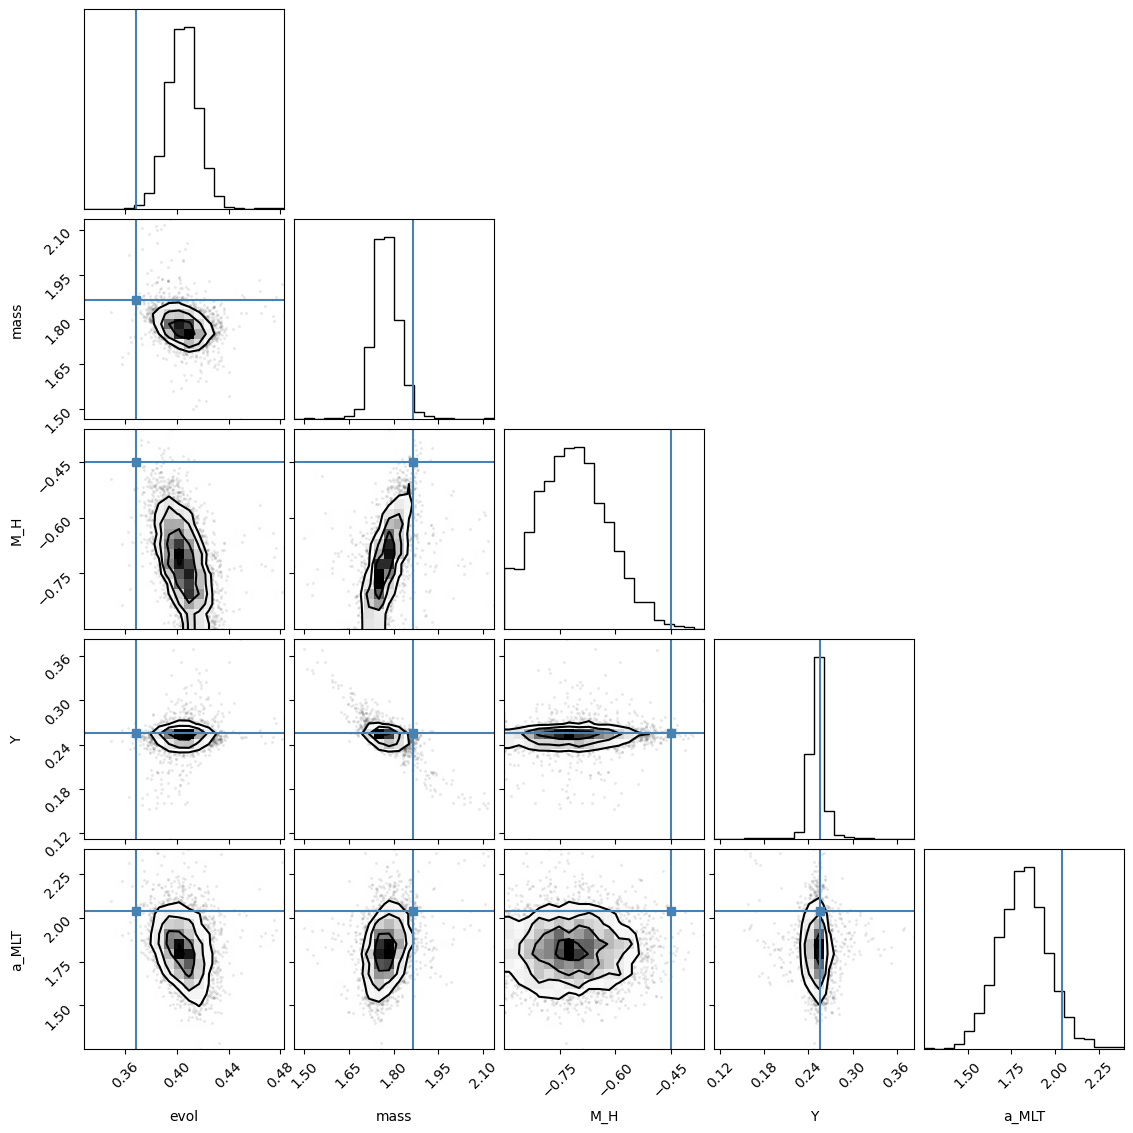

In [30]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

What do we predict for some deterministics?

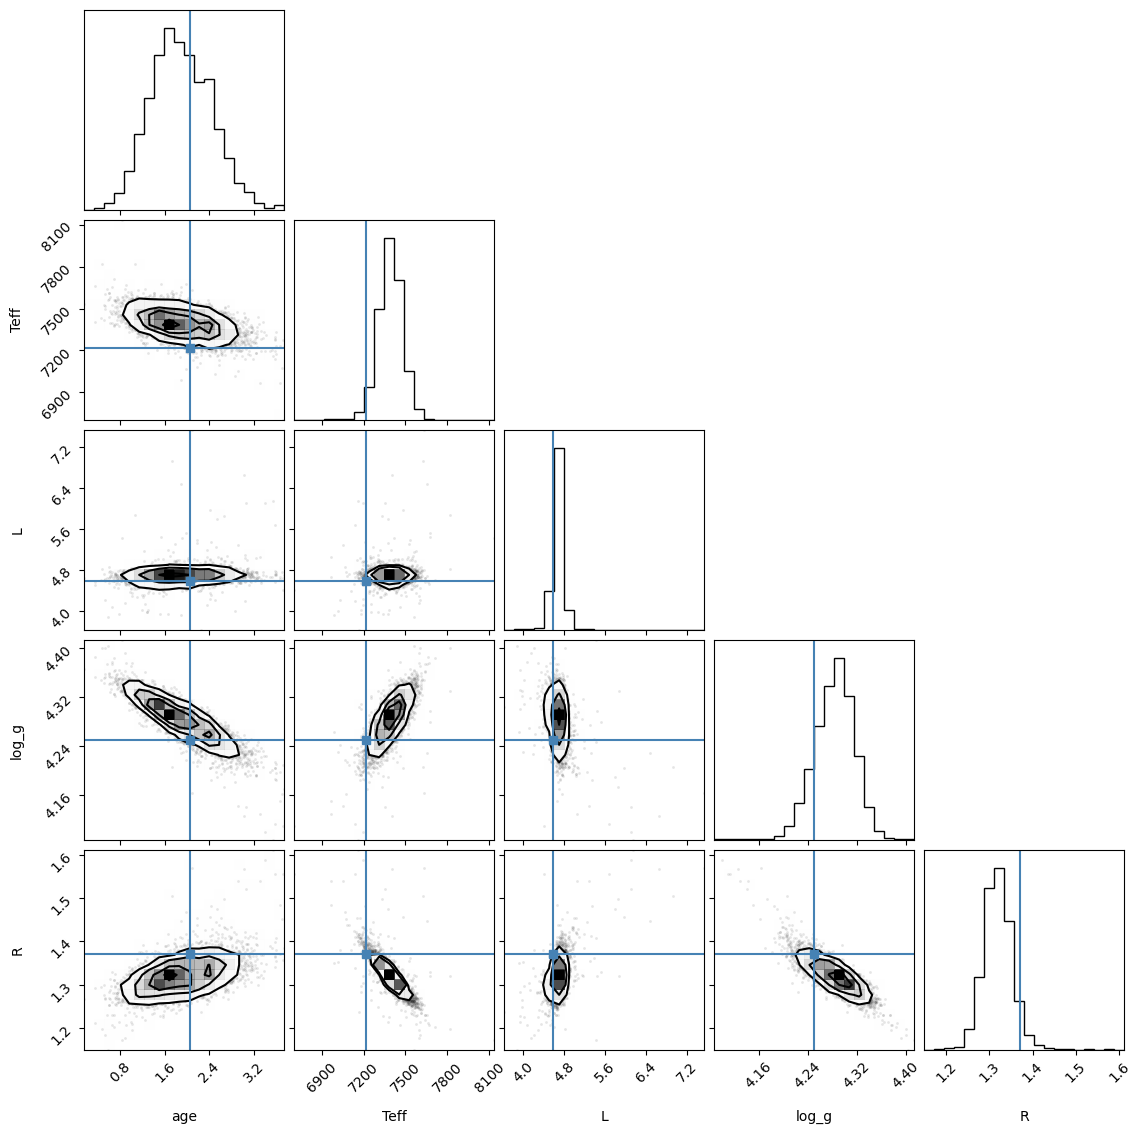

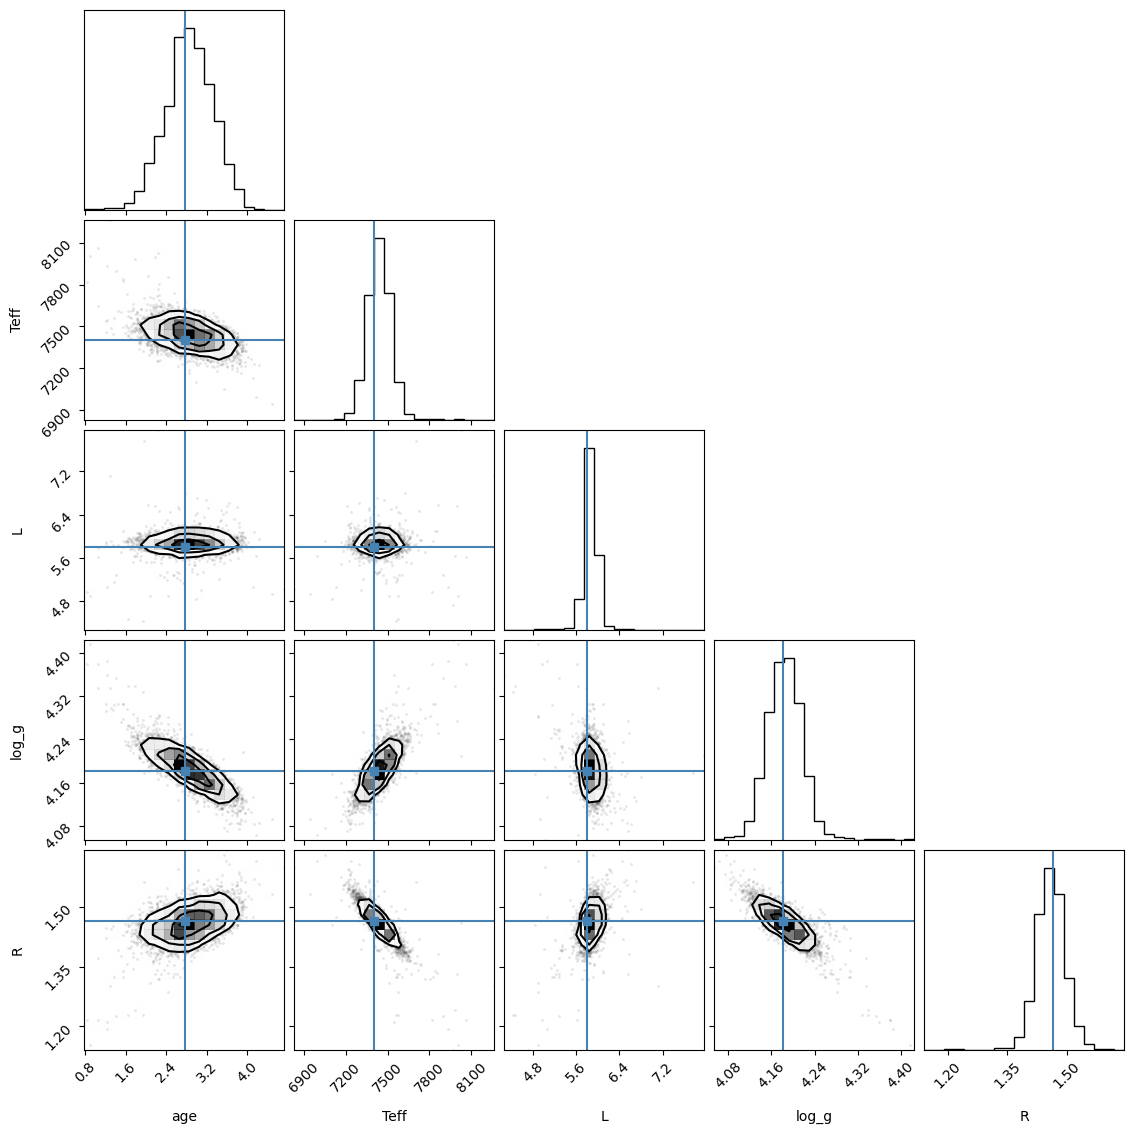

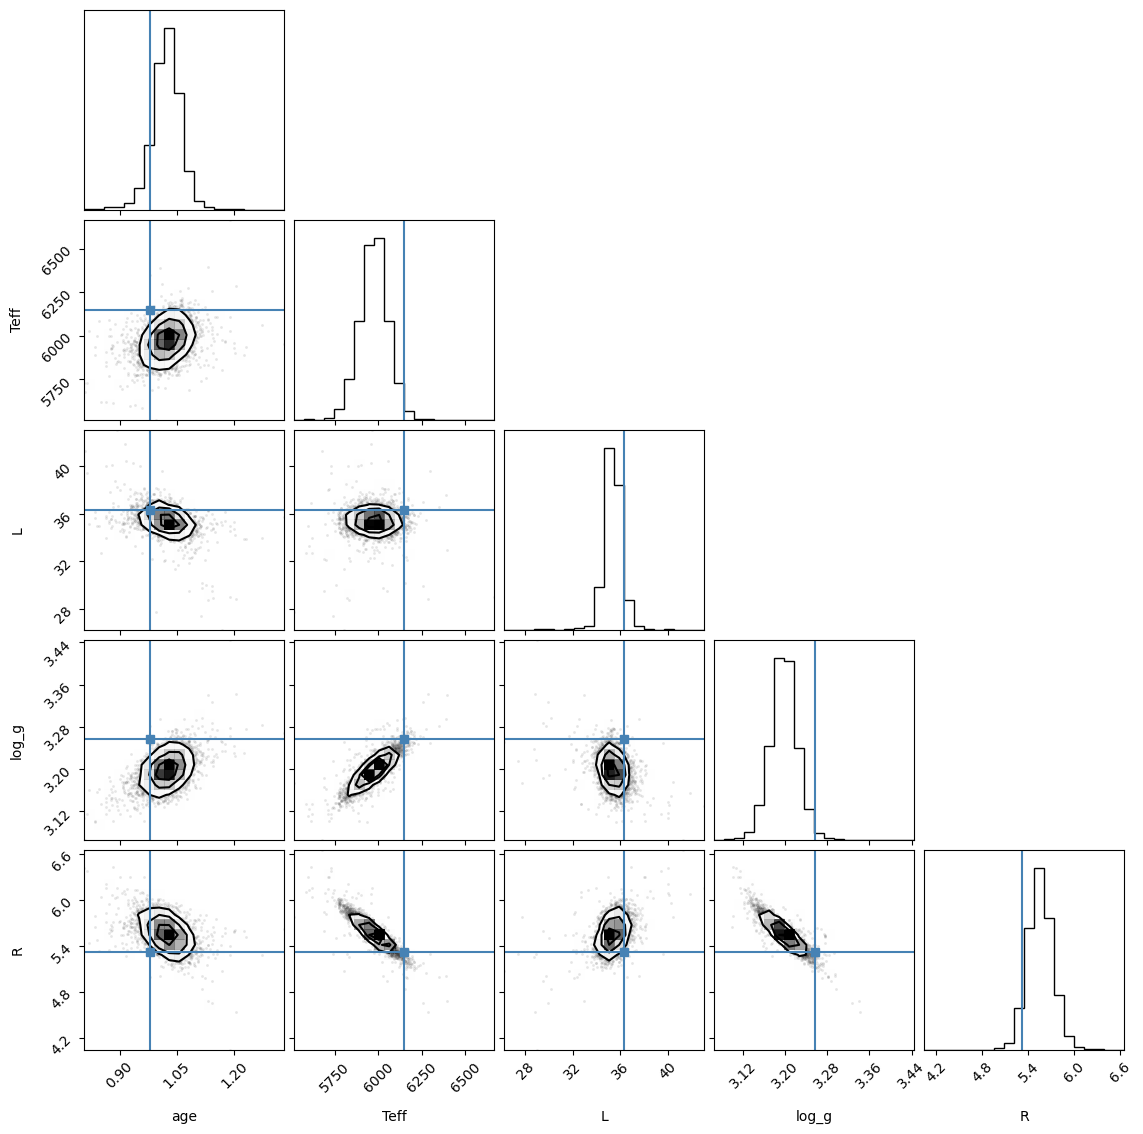

In [31]:
var_names = ["age", "Teff", "L", "log_g", "R"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

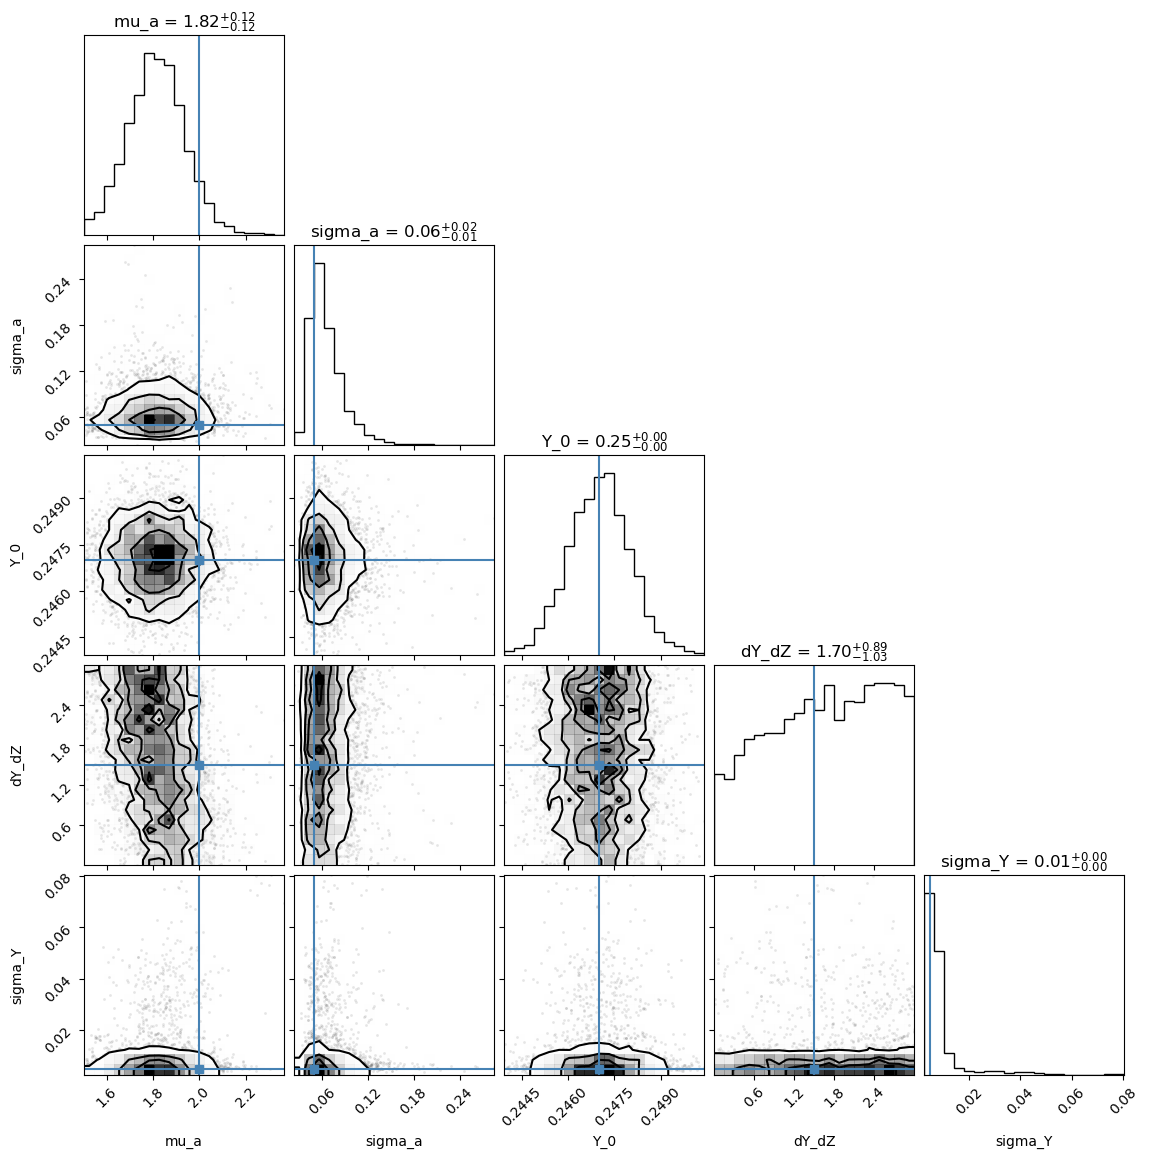

In [32]:
fig = corner(data, group="posterior", var_names=hyperparam_names, truths=truths, show_titles=True)

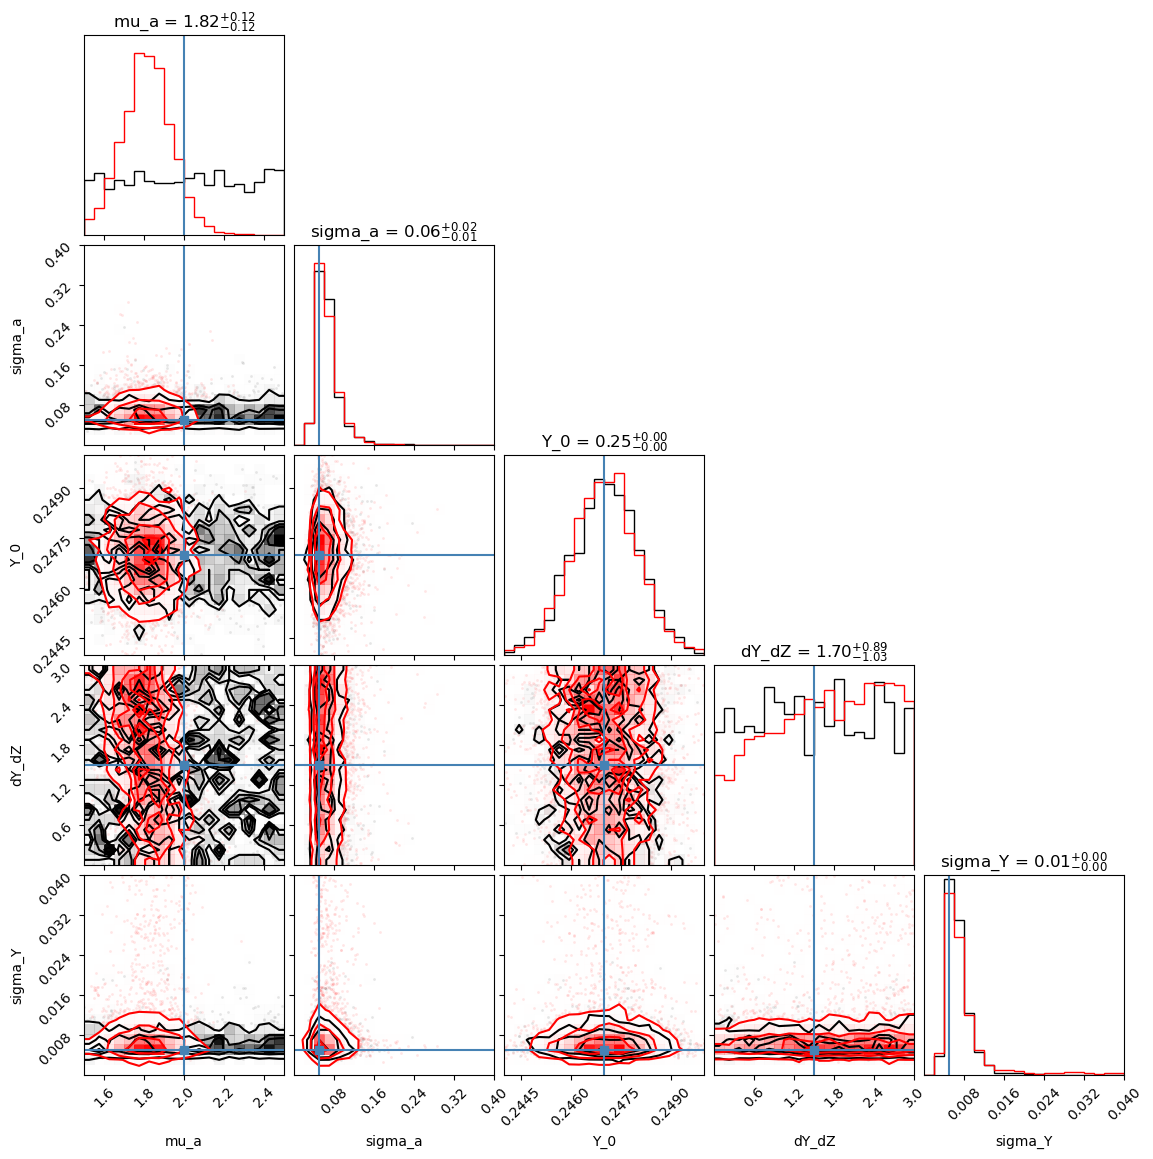

In [33]:
limits = [(1.5, 2.5), (0.0, 0.4), (0.244, 0.250), (0.0, 3.0), (0.0, 0.04)]
hist_kwargs = dict(density=True)
fig = corner(data, group="prior", var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs)

hist_kwargs["color"] = "r"
fig = corner(data, group="posterior", var_names=hyperparam_names, range=limits, hist_kwargs=hist_kwargs,
             color="r", truths=truths, show_titles=True, fig=fig)


Let's look at the fractional error between each posterior sample and the truth. This gives us an idea of the precision and accuracy of our results. Don't expect anything impressive, we are marginalising over `Y` and `a_MLT` after all.

In [ ]:
error = truths - data.posterior
az.summary(error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Dnu[0]   -0.242  3.998  -7.855    6.758      0.157    0.111     647.0   
Dnu[1]   -1.525  3.590  -8.035    5.479      0.173    0.288     444.0   
Dnu[2]   -0.031  0.591  -1.118    1.138      0.028    0.056     480.0   
Dnu[3]    0.389  7.798 -12.937   15.387      0.308    0.218     659.0   
Dnu[4]   -0.883  4.681  -9.008    8.217      0.210    0.167     500.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[98]  0.278  0.286  -0.098    0.614      0.199    0.168       3.0   
mass[99]  0.007  0.221  -0.377    0.393      0.013    0.009     281.0   
mu_a     -0.052  0.068  -0.177    0.081      0.021    0.015      10.0   
sigma_Y  -0.017  0.017  -0.043    0.003      0.012    0.010       3.0   
sigma_a  -0.011  0.025  -0.057    0.026      0.001    0.001     770.0   

          ess_tail  r_hat  
Dnu[0]      1274.0   1.01  
Dnu[1]       586.0   1.03  
Dnu[2]       308.0   1.03  
Dnu[3]      1560.0   1.01  
Dnu[4]       889.0   1.01  
...            ...    ...  
mass[98]      75.0   1.84  
mass[99]     960.0   1.01  
mu_a         191.0   1.15  
sigma_Y       38.0   1.85  
sigma_a     1238.0   1.00  

[1705 rows x 9 columns]

In [ ]:
fractional_error = (truths - data.posterior) / truths
az.summary(fractional_error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Dnu[0]   -0.003  0.046  -0.091    0.078      0.002    0.001     647.0   
Dnu[1]   -0.020  0.047  -0.105    0.071      0.002    0.004     444.0   
Dnu[2]   -0.002  0.040  -0.075    0.076      0.002    0.004     480.0   
Dnu[3]    0.003  0.056  -0.093    0.111      0.002    0.002     659.0   
Dnu[4]   -0.011  0.057  -0.110    0.100      0.003    0.002     500.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[98]  0.132  0.136  -0.047    0.292      0.095    0.080       3.0   
mass[99]  0.006  0.200  -0.341    0.356      0.012    0.008     281.0   
mu_a     -0.026  0.034  -0.089    0.041      0.011    0.008      10.0   
sigma_Y  -3.500  3.451  -8.581    0.530      2.334    1.941       3.0   
sigma_a  -0.213  0.491  -1.149    0.516      0.019    0.013     770.0   

          ess_tail  r_hat  
Dnu[0]      1274.0   1.01  
Dnu[1]       586.0   1.03  
Dnu[2]       308.0   1.03  
Dnu[3]      1560.0   1.01  
Dnu[4]       889.0   1.01  
...            ...    ...  
mass[98]      75.0   1.84  
mass[99]     960.0   1.01  
mu_a         191.0   1.15  
sigma_Y       38.0   1.85  
sigma_a     1238.0   1.00  

[1705 rows x 9 columns]

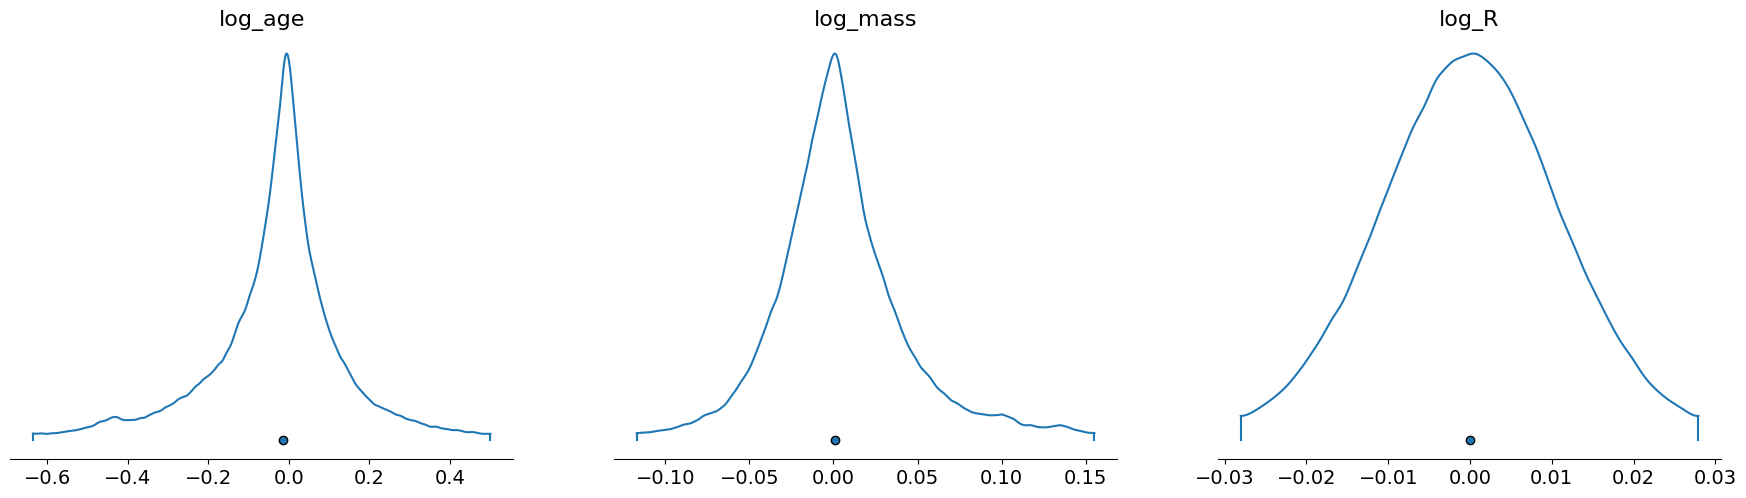

In [ ]:
az.plot_density(error, var_names=["log_age", "log_mass", "log_R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

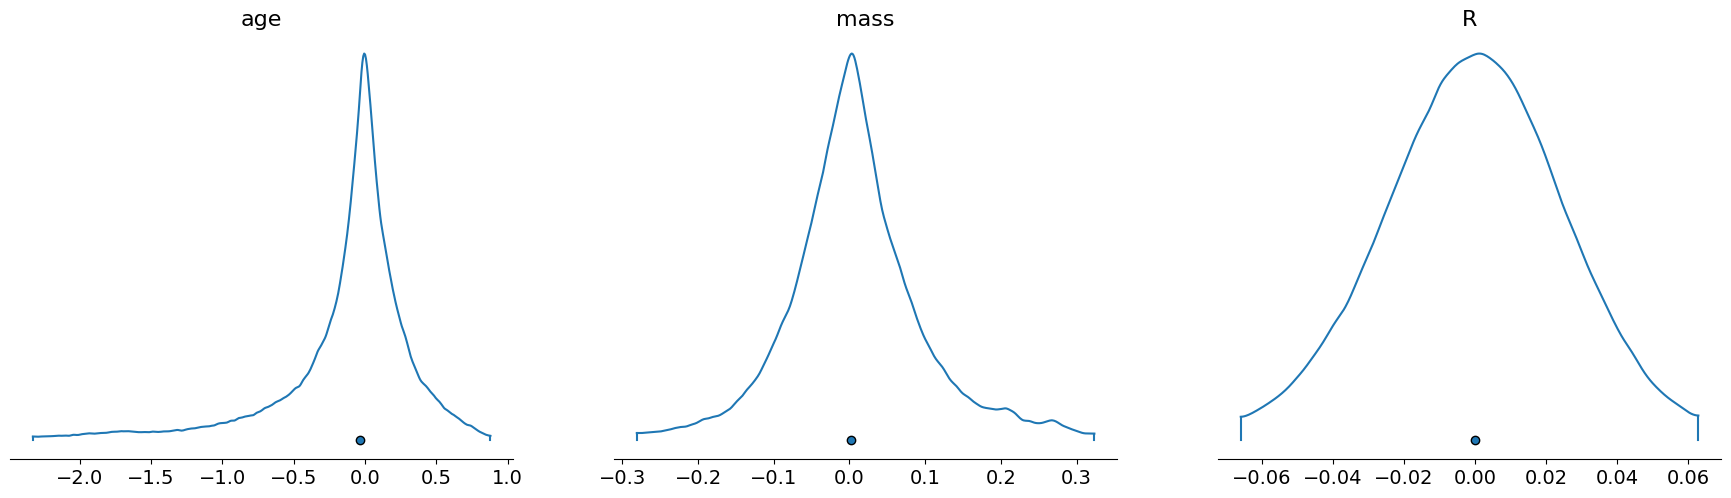

In [ ]:
az.plot_density(fractional_error, var_names=["age", "mass", "R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

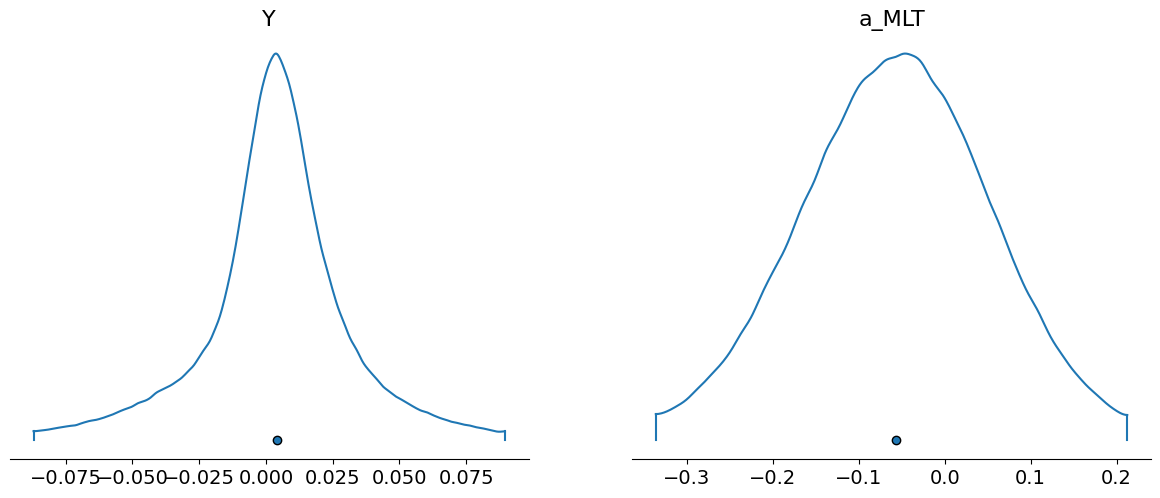

In [ ]:
az.plot_density(error, var_names=["Y", "a_MLT"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

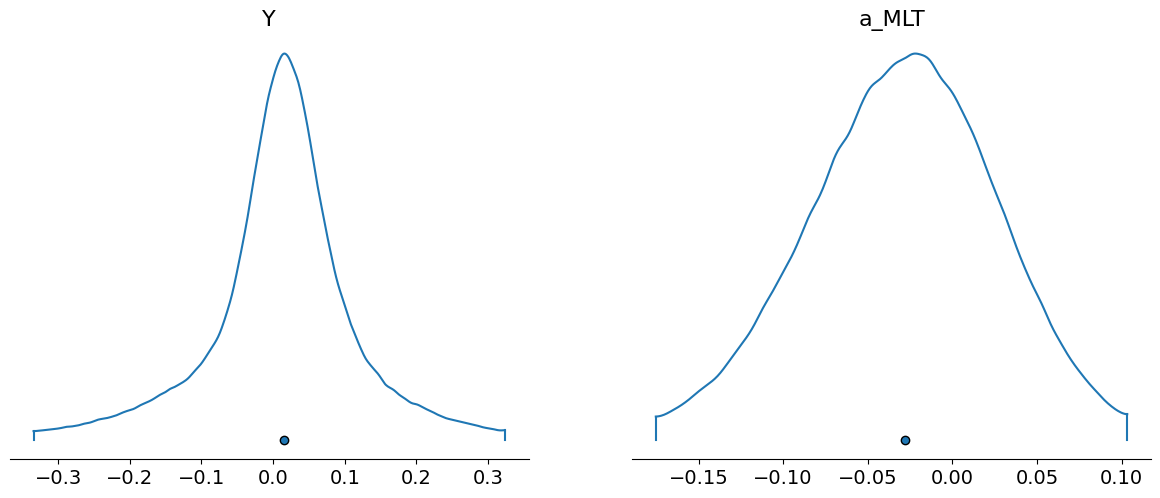

In [ ]:
az.plot_density(fractional_error, var_names=["Y", "a_MLT"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);